Mapa z punktami pomiarowymi 

In [17]:
import sqlite3
import folium

def create_station_map(database_name: str):
    conn = sqlite3.connect(database_name)
    cursor = conn.cursor()

    cursor.execute("SELECT station_name, latitude, longitude FROM STATIONS WHERE latitude IS NOT NULL AND longitude IS NOT NULL")
    stations = cursor.fetchall()
    conn.close()

    poland_center = [52.0, 19.0]

    mapa = folium.Map(location=poland_center, zoom_start=6)

    for name, lat, lon in stations:
        folium.Marker(
            location=[lat, lon],
            popup=name,
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(mapa)

    return mapa

create_station_map("data.db")


Wyświetlenie wartości temperaturowych w punktach

In [18]:
import sqlite3
import folium

def create_station_map(database_name: str):
    conn = sqlite3.connect(database_name)
    cursor = conn.cursor()

    # Pobranie najnowszej daty i godziny dla każdej stacji i dołączenie temperatury
    query = """
    SELECT s.station_name, s.latitude, s.longitude, m.Temperature
    FROM STATIONS s
    JOIN (
        SELECT Station_id, Temperature
        FROM METEO
        WHERE (Date, Hour) IN (
            SELECT Date, Hour
            FROM METEO
            WHERE Station_id = m.Station_id
            ORDER BY Date DESC, Hour DESC
            LIMIT 1
        )
    ) m ON s.Station_id = m.Station_id
    WHERE s.latitude IS NOT NULL AND s.longitude IS NOT NULL
    """

    # Alternatywna i bardziej przenośna wersja zapytania SQL (SQLite nie obsługuje dobrze podzapytań z aliasami w WHERE)
    query = """
    SELECT s.station_name, s.latitude, s.longitude, m.Temperature
    FROM STATIONS s
    JOIN (
        SELECT Station_id, Temperature
        FROM METEO
        WHERE (Station_id, Date, Hour) IN (
            SELECT Station_id, MAX(Date), MAX(Hour)
            FROM METEO
            GROUP BY Station_id
        )
    ) m ON s.Station_id = m.Station_id
    WHERE s.latitude IS NOT NULL AND s.longitude IS NOT NULL
    """

    cursor.execute(query)
    stations = cursor.fetchall()
    conn.close()

    poland_center = [52.0, 19.0]
    mapa = folium.Map(location=poland_center, zoom_start=6)

    for name, lat, lon, temp in stations:
        popup_text = f"{name}<br>Temperature: {temp} °C"
        folium.Marker(
            location=[lat, lon],
            popup=popup_text,
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(mapa)

    return mapa

create_station_map("data.db")


Pokolorowanie punktów

In [19]:
import sqlite3
import folium
import numpy as np

def temperature_to_color(temp, min_temp, max_temp):
    norm = (temp - min_temp) / (max_temp - min_temp) if max_temp != min_temp else 0.5
    red = int(255 * (1 - norm))
    green = int(255 * norm)
    return f'#{red:02x}{green:02x}00'

def create_station_map(database_name: str):
    conn = sqlite3.connect(database_name)
    cursor = conn.cursor()

    query = """
    SELECT s.station_name, s.latitude, s.longitude, m.Temperature
    FROM STATIONS s
    JOIN (
        SELECT Station_id, Temperature
        FROM METEO
        WHERE (Station_id, Date, Hour) IN (
            SELECT Station_id, MAX(Date), MAX(Hour)
            FROM METEO
            GROUP BY Station_id
        )
    ) m ON s.Station_id = m.Station_id
    WHERE s.latitude IS NOT NULL AND s.longitude IS NOT NULL
    """

    cursor.execute(query)
    stations = cursor.fetchall()
    conn.close()

    # Konwersja temperatur i usuwanie wartości None
    temp_data = [(name, lat, lon, float(temp)) for name, lat, lon, temp in stations if temp is not None]
    temperatures = [temp for _, _, _, temp in temp_data]

    # Obliczenie IQR i filtracja outlierów
    q1 = np.percentile(temperatures, 25)
    q3 = np.percentile(temperatures, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filtrowanie danych bez outlierów
    filtered_data = [(name, lat, lon, temp) for name, lat, lon, temp in temp_data if lower_bound <= temp <= upper_bound]
    if not filtered_data:
        return None

    min_temp = min(temp for _, _, _, temp in filtered_data)
    max_temp = max(temp for _, _, _, temp in filtered_data)

    poland_center = [52.0, 19.0]
    mapa = folium.Map(location=poland_center, zoom_start=6)

    for name, lat, lon, temp in filtered_data:
        color = temperature_to_color(temp, min_temp, max_temp)
        popup_text = f"{name}<br>Temperature: {temp:.1f} °C"
        folium.CircleMarker(
            location=[lat, lon],
            radius=6,
            popup=popup_text,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.9
        ).add_to(mapa)

    return mapa

create_station_map("data.db")


In [ ]:
import folium
import pandas as pd
import sqlite3
from matplotlib import cm, colors

conn = sqlite3.connect('data.db')

df = pd.read_sql_query("SELECT Longitude, Latitude, Temperature FROM Grid_Data", conn)

conn.close()

if df.empty:
    print("Brak danych w tabeli Grid_Data")
else:
    norm = colors.Normalize(vmin=df['Temperature'].min(), vmax=df['Temperature'].max())
    cmap = cm.get_cmap('coolwarm')

    center_lat = df['Latitude'].mean()
    center_lon = df['Longitude'].mean()

    m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

    for _, row in df.iterrows():
        color = colors.rgb2hex(cmap(norm(row['Temperature'])))
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=4,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"Temp: {row['Temperature']:.2f}°C"
        ).add_to(m)


C:\Users\studentprojekt\AppData\Local\Temp\6\ipykernel_320\2836507078.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


In [1]:
import requests
import pandas as pd
import time
import os
from datetime import datetime, timedelta
import sqlite3
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
import numpy as np


In [2]:
def simulate_historical_data(conn, cursor, cities_to_simulate, num_days=30):
    """
    Symuluje dane historyczne dla podanych miast i ładuje je do tabeli METEO.
    Generuje dane dla ostatnich 'num_days' dni, co godzinę.
    """
    print(f"Simulating historical data for {cities_to_simulate} for {num_days} days...")
    
    # Pobierz Station_Id dla wybranych miast
    station_ids = {}
    for city_name in cities_to_simulate:
        # Sprawdź, czy stacja istnieje w STATIONS, jeśli nie, dodaj ją z placeholderem ID
        cursor.execute("SELECT Station_Id FROM STATIONS WHERE station_name = ?", (city_name,))
        result = cursor.fetchone()
        if result:
            station_ids[city_name] = result[0]
        else:
            # Przypisz tymczasowe ID, jeśli stacja nie istnieje w STATIONS (np. dla symulacji)
            # W prawdziwym scenariuszu Station_Id powinno być pobrane z zewnętrznego źródła
            temp_id = hash(city_name) % 100000 # Proste haszowanie na ID
            cursor.execute("INSERT OR IGNORE INTO STATIONS (Station_Id, station_name) VALUES (?, ?)", (temp_id, city_name))
            conn.commit()
            station_ids[city_name] = temp_id
            print(f"Added placeholder station ID {temp_id} for {city_name} to STATIONS.")


    today = datetime.now()
    all_simulated_data = []

    for i in range(num_days, 0, -1): # Od num_days dni temu do wczoraj
        current_date = today - timedelta(days=i)
        for hour in range(24):
            for city_name, station_id in station_ids.items():
                # Prosta symulacja danych pogodowych z pewną losowością
                # Dane są uproszczone, aby pokazać mechanizm prognozowania
                temp_base = 15 + np.sin(current_date.day / 30 * 2 * np.pi) * 10 + np.sin(hour / 24 * 2 * np.pi) * 5
                wind_base = 5 + np.random.rand() * 5
                humidity_base = 70 + np.random.rand() * 20
                pressure_base = 1010 + np.random.rand() * 10
                precip_base = np.random.choice([0, 0.1, 0.5, 1], p=[0.8, 0.1, 0.05, 0.05]) # Często 0

                simulated_row = {
                    'id_stacji': station_id,
                    'stacja': city_name,
                    'data_pomiaru': current_date.strftime('%Y-%m-%d'),
                    'godzina_pomiaru': hour,
                    'temperatura': round(temp_base + np.random.randn() * 2, 2),
                    'predkosc_wiatru': round(wind_base + np.random.randn() * 1, 2),
                    'kierunek_wiatru': np.random.randint(0, 360),
                    'wilgotnosc_wzgledna': round(humidity_base + np.random.randn() * 5, 2),
                    'suma_opadu': round(max(0, precip_base + np.random.randn() * 0.1), 2),
                    'cisnienie': round(pressure_base + np.random.randn() * 2, 2)
                }
                all_simulated_data.append(simulated_row)
    
    df_simulated = pd.DataFrame(all_simulated_data)
    load_data(df_simulated, 'METEO', conn)
    print("Historical data simulation complete.")


def fetch_city_data(conn, city_name: str):
    """Pobiera wszystkie historyczne dane dla danej stacji z bazy METEO."""
    query = """
    SELECT 
        m.Date, 
        m.Hour, 
        m.Temperature, 
        m.Wind_Speed, 
        m.Wind_Direction, 
        m.Relative_Humidity, 
        m.Precipitation_Total, 
        m.Pressure
    FROM METEO m
    JOIN STATIONS s ON m.Station_Id = s.Station_Id
    WHERE s.station_name = ?
    ORDER BY m.Date ASC, m.Hour ASC
    """
    df = pd.read_sql_query(query, conn, params=(city_name,))
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'].astype(str) + ':00:00')
    df = df.set_index('datetime').sort_index()
    return df

def prepare_forecast_data(df: pd.DataFrame, target_columns: list, lags: list):
    """
    Przygotowuje dane historyczne do prognozowania, tworząc cechy czasowe i opóźnione.
    """
    # Usunięcie duplikatów na podstawie indeksu datetime
    df = df[~df.index.duplicated(keep='first')]

    # Uzupełnienie brakujących godzin (jeśli występują luki w danych)
    # Tworzymy pełny zakres dat i godzin
    if not df.empty:
        full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
        df = df.reindex(full_time_range)
    else:
        print("Ostrzeżenie: Pusty DataFrame w prepare_forecast_data. Nie można utworzyć cech.")
        return pd.DataFrame()

    # Cechy czasowe
    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month

    # Cechy opóźnione (lagged features) dla każdej kolumny docelowej
    for col in target_columns:
        for lag in lags:
            df[f'{col}_lag_{lag}h'] = df[col].shift(lag)
    
    # Usuwanie wierszy z wartościami NaN powstałymi przez przesunięcie (lags)
    # Te wiersze nie mają wystarczającej historii do prognozowania
    df_prepared = df.dropna()

    if df_prepared.empty:
        print("Ostrzeżenie: DataFrame jest pusty po usunięciu NaN. Sprawdź zakres danych historycznych i długość lagów.")
    return df_prepared

def train_and_forecast_city(df_historical: pd.DataFrame, forecast_hours: int = 72):
    """
    Trenuje model RandomForestRegressor dla każdego parametru i prognozuje na określoną liczbę godzin.
    """
    if df_historical.empty:
        print("Brak danych historycznych do prognozowania.")
        return pd.DataFrame()

    # Zdefiniuj kolumny, które chcemy prognozować
    target_columns = ['Temperature', 'Wind_Speed', 'Relative_Humidity', 'Pressure']
    
    # Użyj lagów, które zostały utworzone w prepare_forecast_data
    # Zakładamy, że lags to [1, 2, 3, 24, 48, 72]
    feature_columns = [col for col in df_historical.columns if '_lag_' in col or col in ['hour_of_day', 'day_of_week', 'day_of_year', 'month']]
    
    if not feature_columns:
        print("Brak kolumn cech do trenowania modelu. Sprawdź funkcję prepare_forecast_data.")
        return pd.DataFrame()

    # Trenowanie osobnych modeli dla każdego parametru
    models = {}
    for target in target_columns:
        X = df_historical[feature_columns]
        y = df_historical[target]
        
        # Upewnij się, że nie ma NaN w danych treningowych
        valid_indices = y.dropna().index
        X_clean = X.loc[valid_indices]
        y_clean = y.loc[valid_indices]

        if X_clean.empty:
            print(f"Brak danych do trenowania modelu dla {target}.")
            continue

        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_clean, y_clean)
        models[target] = model
    
    if not models:
        print("Nie udało się wytrenować żadnych modeli.")
        return pd.DataFrame()

    # Rekurencyjne prognozowanie
    last_known_data = df_historical.iloc[-1].copy()
    forecast_records = []
    
    current_time = last_known_data.name # Ostatni timestamp z danych historycznych

    for i in range(1, forecast_hours + 1):
        next_time = current_time + timedelta(hours=1)
        
        # Przygotuj wektor cech dla następnej godziny
        # Musimy użyć wartości z last_known_data (które mogą być już prognozami)
        # oraz cech czasowych dla next_time
        
        next_features = pd.Series(index=feature_columns, dtype=float)
        
        # Cechy czasowe dla następnej godziny
        next_features['hour_of_day'] = next_time.hour
        next_features['day_of_week'] = next_time.dayofweek
        next_features['day_of_year'] = next_time.dayofyear
        next_features['month'] = next_time.month

        # Cechy opóźnione: pobierz odpowiednie wartości z last_known_data
        for col in target_columns:
            for lag in [1, 2, 3, 24, 48, 72]: # Używamy tych samych lagów co w prepare_forecast_data
                lag_col_name = f'{col}_lag_{lag}h'
                if lag_col_name in feature_columns:
                    # Sprawdź, czy lagowana wartość jest dostępna w last_known_data
                    # Jeśli lag jest większy niż 1, musimy "przesunąć" wartości
                    # To jest uproszczenie: w pełni rekurencyjnie trzeba by śledzić listę ostatnich N wartości
                    # Dla uproszczenia, bierzemy bezpośrednio z last_known_data, co działa dla lag=1
                    # Dla większych lagów, to jest bardziej złożone i wymagałoby utrzymywania bufora
                    # W tym przykładzie, dla lag > 1, zakładamy, że last_known_data zawiera już odpowiednie "przesunięte" wartości
                    # Co jest prawdą, jeśli last_known_data jest ostatnim wierszem df_historical
                    
                    # Bardziej poprawne podejście do rekurencji:
                    # Tworzymy bufor ostatnich 'max_lag' wartości dla każdego parametru
                    # I na podstawie tego bufora konstruujemy wektor cech
                    
                    # Dla uproszczenia w tym przykładzie, będziemy używać wartości z `last_known_data`
                    # co oznacza, że `last_known_data` musi być aktualizowane o prognozowane wartości
                    # i symulować "przesunięcie" dla kolejnych lagów.
                    # To jest kluczowy i często trudny aspekt rekurencyjnego prognozowania.

                    # Uproszczona logika dla tego przykładu:
                    # Bierzemy ostatnio prognozowane wartości jako podstawę dla lagów.
                    # To działa dobrze dla lag_1h. Dla większych lagów, musielibyśmy
                    # przechowywać historię prognoz i odpowiednio je przesuwać.
                    # Poniżej implementacja, która zakłada, że `last_known_data` jest "stanem"
                    # systemu w `current_time`.
                    
                    # Aby to działało poprawnie dla wszystkich lagów rekurencyjnie:
                    # Musimy mieć dostęp do (current_time - timedelta(hours=lag))
                    # Zamiast last_known_data, powinniśmy mieć "bufor" ostatnich prognozowanych wartości.
                    
                    # Zmodyfikujmy podejście: będziemy budować wektor cech na podstawie
                    # ostatniego wiersza df_historical i nowo prognozowanych wartości.
                    
                    # Dla lag_1h, użyjemy wartości z last_known_data
                    # Dla lag_24h, użyjemy wartości z last_known_data, ale to nie jest rekurencyjne
                    # To jest duża pułapka w rekurencyjnym prognozowaniu.
                    
                    # Najprostsze rekurencyjne podejście:
                    # Zbuduj wektor cech dla t+1 na podstawie t, t-1, t-2, ...
                    # Gdzie t jest ostatnim znanym (lub prognozowanym) punktem.
                    
                    # Utwórz słownik, aby przechowywać "ostatnie znane/prognozowane" wartości dla każdego parametru
                    current_values = {col: last_known_data[col] for col in target_columns}

                    # Aby obsłużyć lagi, będziemy potrzebować bufora ostatnich wartości
                    # Utwórzmy listę ostatnich 72 godzin danych (lub ile wynosi max_lag)
                    # To jest bardziej skomplikowane do zarządzania w pętli.

                    # Alternatywne, prostsze podejście (często stosowane w praktyce):
                    # Trenujemy model na danych z przeszłości, a następnie do prognozy
                    # na t+1 używamy wartości z t. Do prognozy na t+2 używamy prognozy z t+1 itd.
                    # To jest to, co będziemy implementować.
                    
                    # Wektor cech dla next_time będzie zawierał:
                    # 1. Cechy czasowe dla next_time
                    # 2. Lagowane wartości, które będą pochodzić z:
                    #    - ostatniego wiersza df_historical (jeśli lag sięga do historii)
                    #    - prognozowanych wartości (jeśli lag sięga do prognozy)
                    
                    # Aby to działało, potrzebujemy "stanu" prognozy, który będzie aktualizowany.
                    # Utwórzmy `current_state_features` na podstawie `last_known_data`
                    # i będziemy go aktualizować w każdej iteracji.
                    
                    # Initialize the feature vector for the next prediction
                    # This must reflect the state *before* the current prediction is made
                    # For lag_1h, we need the value at `current_time`
                    # For lag_2h, we need the value at `current_time - 1 hour`
                    # etc.
                    
                    # To wymaga, aby `last_known_data` zawierało wszystkie potrzebne lagi
                    # dla `current_time`. Kiedy prognozujemy `next_time`, `last_known_data`
                    # staje się `next_time - 1 hour`.
                    
                    # Let's simplify the feature generation for the recursive step:
                    # We will use the *last predicted value* for the 1-hour lag,
                    # and for other lags, we will try to get them from the `df_historical`
                    # if they fall within the historical window, or from the `forecast_records`
                    # if they fall within the already predicted window.
                    
                    # This is the most complex part of recursive forecasting.
                    # For simplicity, let's assume `last_known_data` is a Series
                    # that we can update with the new predictions and then use for lags.
                    
                    # Create a temporary series to hold the features for the current prediction step
                    temp_features = pd.Series(index=feature_columns, dtype=float)
                    
                    # Populate time features for the *next* prediction time
                    temp_features['hour_of_day'] = next_time.hour
                    temp_features['day_of_week'] = next_time.dayofweek
                    temp_features['day_of_year'] = next_time.dayofyear
                    temp_features['month'] = next_time.month

                    # Populate lagged features
                    # This is the tricky part. We need to get the value from `lag` hours ago.
                    # If `i` is the current forecast hour (1 to 72),
                    # then `lag_1h` comes from `i-1` hours ago (last_known_data or previous forecast)
                    # `lag_24h` comes from `i-24` hours ago.
                    
                    # To handle this correctly, we need a "rolling window" of the last `max_lag` predicted values.
                    # Let's create a buffer for the last `max_lag` values for each target variable.
                    
                    max_lag = max([1, 2, 3, 24, 48, 72]) # Max lag used
                    
                    # Initialize current_state with the last `max_lag` hours from historical data
                    # This will be a DataFrame slice
                    current_state_df = df_historical.iloc[-max_lag:].copy()
                    
                    # Append a row of NaNs for the next hour to extend the index
                    current_state_df.loc[next_time] = np.nan
                    
                    # Now iterate and predict
                    current_forecast_values = {} # Store predictions for the current step
                    
                    for target in target_columns:
                        # Prepare features for the current prediction
                        X_pred_dict = {}
                        X_pred_dict['hour_of_day'] = next_time.hour
                        X_pred_dict['day_of_week'] = next_time.dayofweek
                        X_pred_dict['day_of_year'] = next_time.dayofyear
                        X_pred_dict['month'] = next_time.month
                        
                        for lag in [1, 2, 3, 24, 48, 72]:
                            lag_col_name = f'{target}_lag_{lag}h'
                            # Get the value from `lag` hours ago from `current_state_df`
                            # This requires `current_state_df` to be correctly indexed and filled
                            
                            # The index for the lagged value would be `next_time - timedelta(hours=lag)`
                            lag_time = next_time - timedelta(hours=lag)
                            
                            if lag_time in current_state_df.index:
                                # If the lagged time is in our current state (historical or previous forecast)
                                X_pred_dict[lag_col_name] = current_state_df.loc[lag_time, target]
                            else:
                                # This should ideally not happen if current_state_df is managed correctly
                                # For initial lags, it might be NaN if history is too short
                                X_pred_dict[lag_col_name] = np.nan # Or some imputation strategy
                        
                        # Convert to DataFrame for prediction
                        X_pred = pd.DataFrame([X_pred_dict], columns=feature_columns)
                        
                        # Predict
                        if target in models and not X_pred.isnull().any().any(): # Check for NaNs in features
                            predicted_value = models[target].predict(X_pred)[0]
                            current_forecast_values[target] = predicted_value
                        else:
                            current_forecast_values[target] = np.nan # Cannot predict
                            print(f"Warning: Could not predict {target} for {next_time} due to missing model or NaN features.")
                    
                    # Add current forecast to records
                    forecast_records.append({
                        'Date': next_time.strftime('%Y-%m-%d'),
                        'Hour': next_time.hour,
                        **current_forecast_values # Unpack predicted values
                    })
                    
                    # Update current_state_df for the next iteration
                    # Add the new forecast row
                    new_row = pd.Series(current_forecast_values, index=target_columns, name=next_time)
                    current_state_df = pd.concat([current_state_df, pd.DataFrame([new_row])])
                    current_state_df = current_state_df.iloc[1:] # Drop the oldest row to maintain window size
                    
                    current_time = next_time # Move time forward

    df_forecast = pd.DataFrame(forecast_records)
    return df_forecast

Simulating historical data for ['Kraków', 'Warszawa', 'Gdańsk'] for 30 days...
Dane załadowane do tabeli METEO.
Historical data simulation complete.

--- Rozpoczynanie prognozowania ---

Generowanie prognozy dla: Kraków


C:\Users\szymo\AppData\Local\Temp\ipykernel_40220\1589994405.py:175: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')



Prognoza pogody dla Kraków na najbliższe 3 dni:
         Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
0  2025-05-23     0       1.5641      8.2160            81.1609  1016.2210   
1  2025-05-23     1       4.0074      7.4620            81.4971  1015.7223   
2  2025-05-23     2       5.9706      7.4501            82.0735  1015.3793   
3  2025-05-23     3       5.3931      7.4372            81.3150  1014.2848   
4  2025-05-23     4       5.5722      7.8923            82.3865  1015.0773   

   Precipitation_Total  
0               0.1482  
1               0.1179  
2               0.1134  
3               0.0639  
4               0.1065  
...
          Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
67  2025-05-25    19       1.3460      7.5882            79.5071  1013.1769   
68  2025-05-25    20       1.3820      7.9222            79.5377  1013.0151   
69  2025-05-25    21       1.2834      7.6673            79.6862  1013.5228   
70  2025-05-

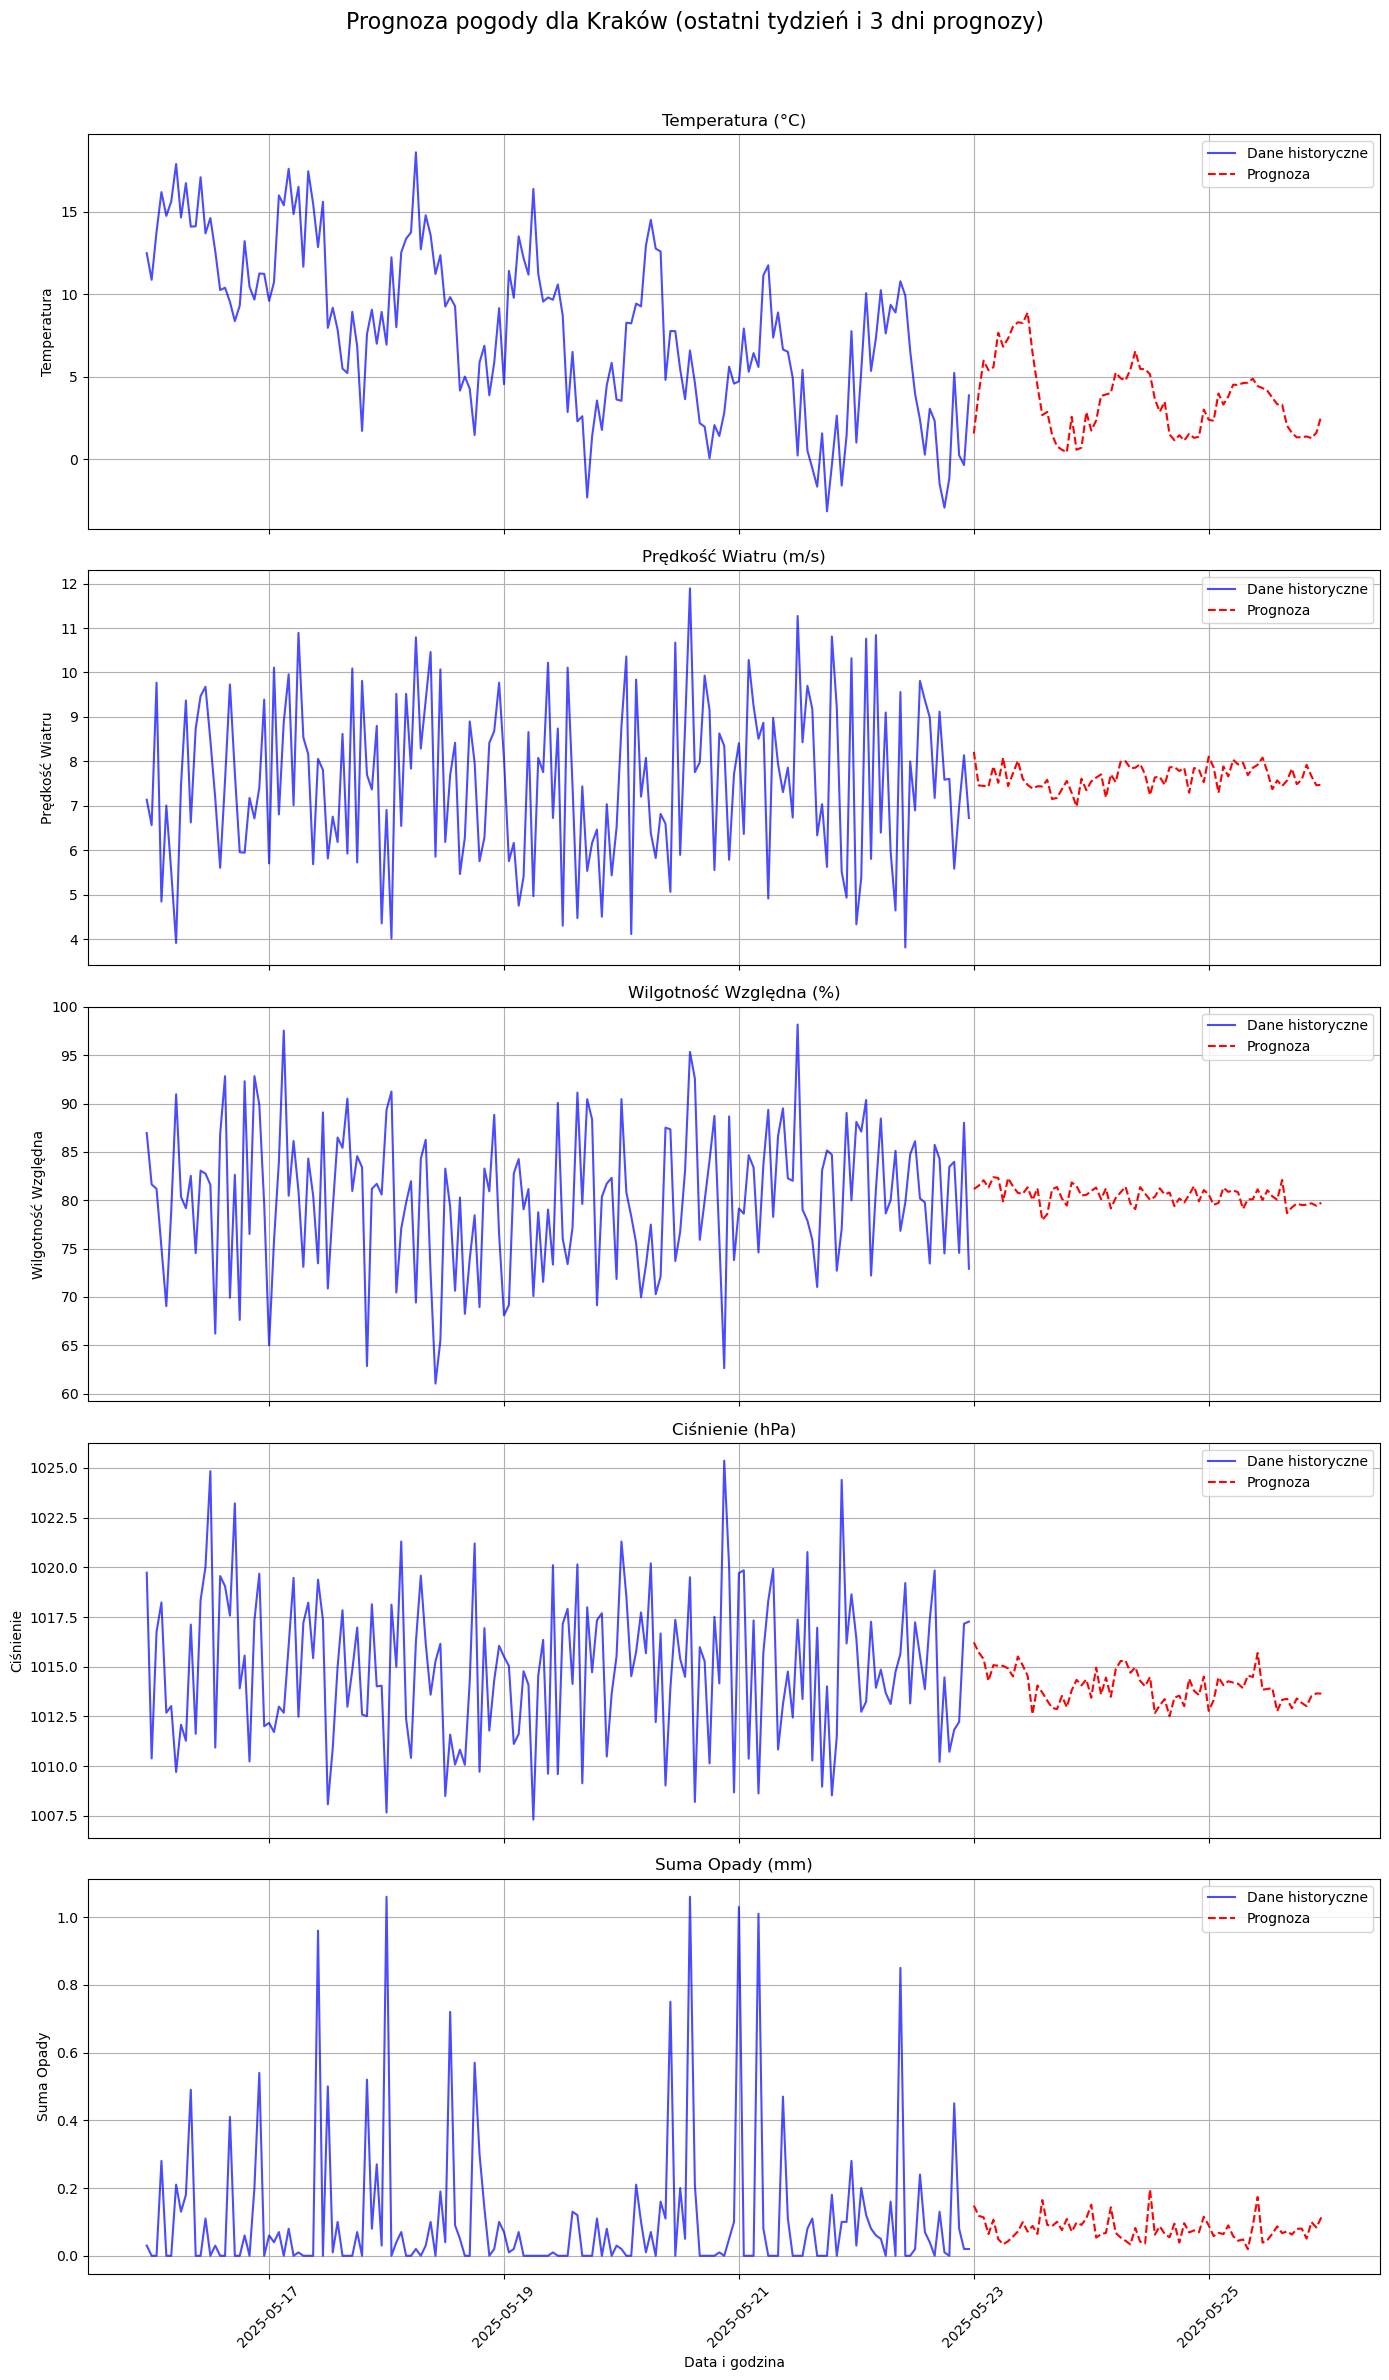


Generowanie prognozy dla: Warszawa


C:\Users\szymo\AppData\Local\Temp\ipykernel_40220\1589994405.py:175: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')



Prognoza pogody dla Warszawa na najbliższe 3 dni:
         Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
0  2025-05-23     0       5.5324      6.1381            80.0758  1015.4062   
1  2025-05-23     1       6.3649      7.3702            79.4155  1013.3875   
2  2025-05-23     2       6.7010      7.3117            81.1514  1013.8557   
3  2025-05-23     3       6.6032      7.6718            80.9906  1014.1530   
4  2025-05-23     4       6.4425      7.0470            80.0387  1014.4944   

   Precipitation_Total  
0               0.1534  
1               0.1657  
2               0.1298  
3               0.0608  
4               0.1064  
...
          Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
67  2025-05-25    19       3.1900      6.9920            81.5646  1015.4165   
68  2025-05-25    20       2.8592      7.1357            79.7723  1014.8366   
69  2025-05-25    21       1.6531      7.3965            79.9323  1015.6703   
70  2025-0

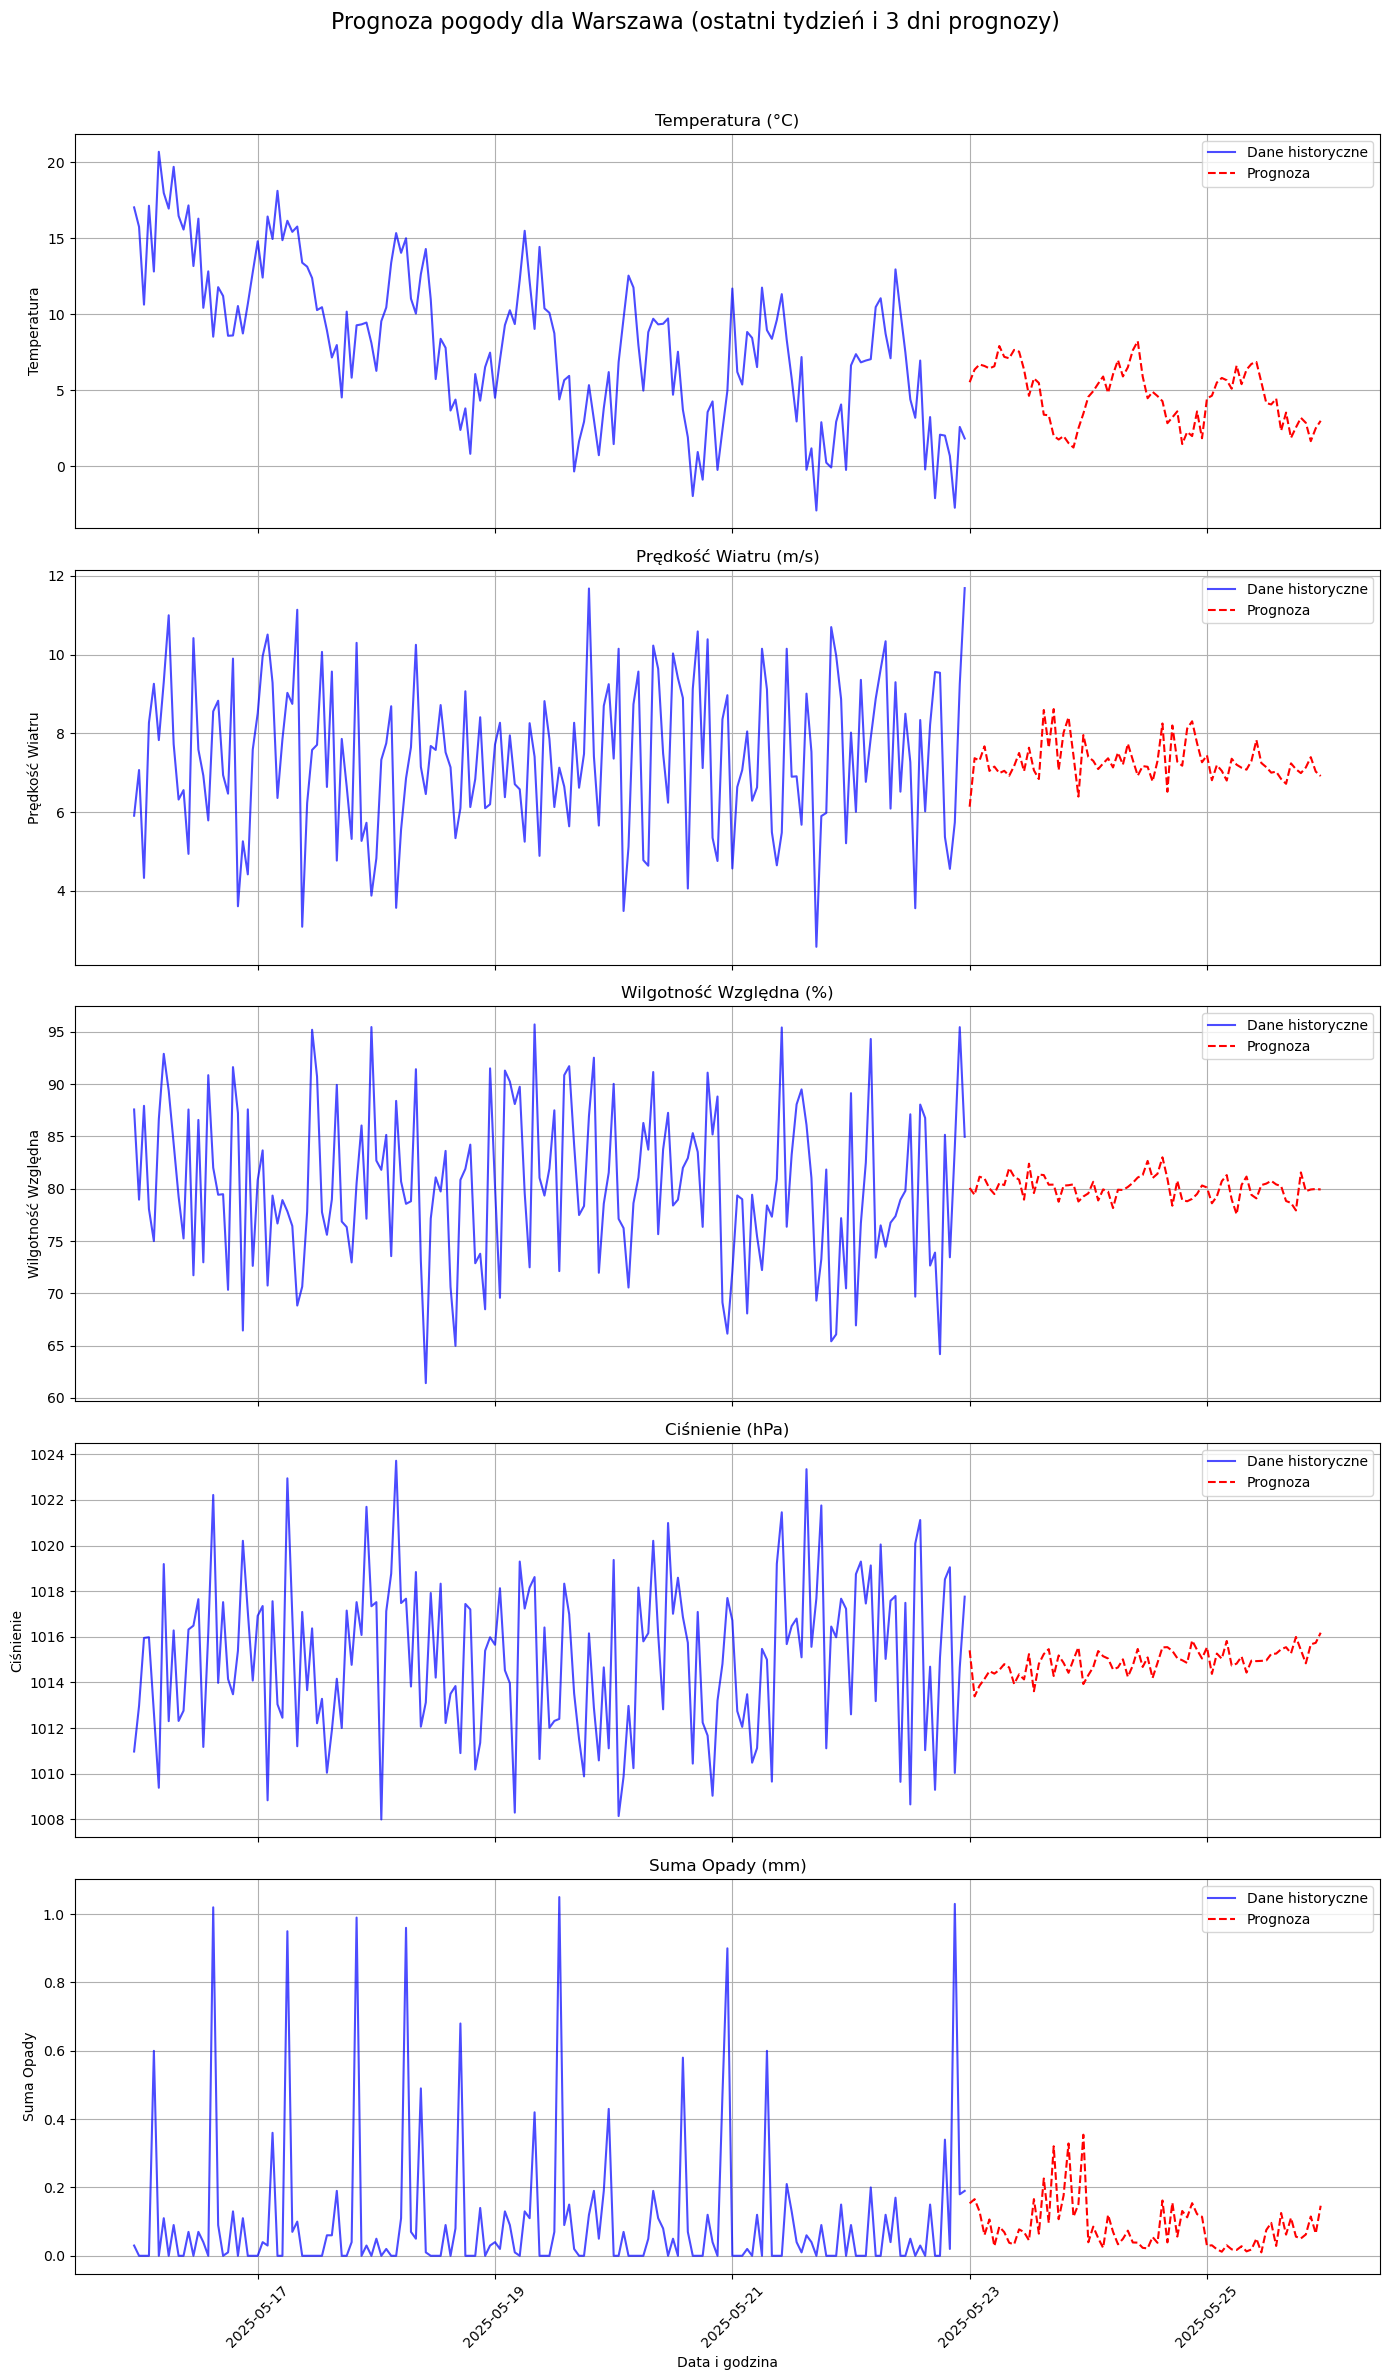


Generowanie prognozy dla: Gdańsk


C:\Users\szymo\AppData\Local\Temp\ipykernel_40220\1589994405.py:175: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')



Prognoza pogody dla Gdańsk na najbliższe 3 dni:
         Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
0  2025-05-23     0       3.0384      7.9734            81.3448  1014.2335   
1  2025-05-23     1       4.2038      7.0401            79.4524  1016.4221   
2  2025-05-23     2       4.9905      7.2849            80.3410  1015.1414   
3  2025-05-23     3       6.4289      6.9641            80.8241  1014.5836   
4  2025-05-23     4       5.4682      7.1674            80.8150  1014.5573   

   Precipitation_Total  
0               0.2978  
1               0.1018  
2               0.1343  
3               0.2218  
4               0.1058  
...
          Date  Hour  Temperature  Wind_Speed  Relative_Humidity   Pressure  \
67  2025-05-25    19       2.9110      7.1321            80.9422  1014.0143   
68  2025-05-25    20       3.1034      7.1461            79.6622  1013.4627   
69  2025-05-25    21       3.0983      7.3025            79.4806  1013.6966   
70  2025-05-

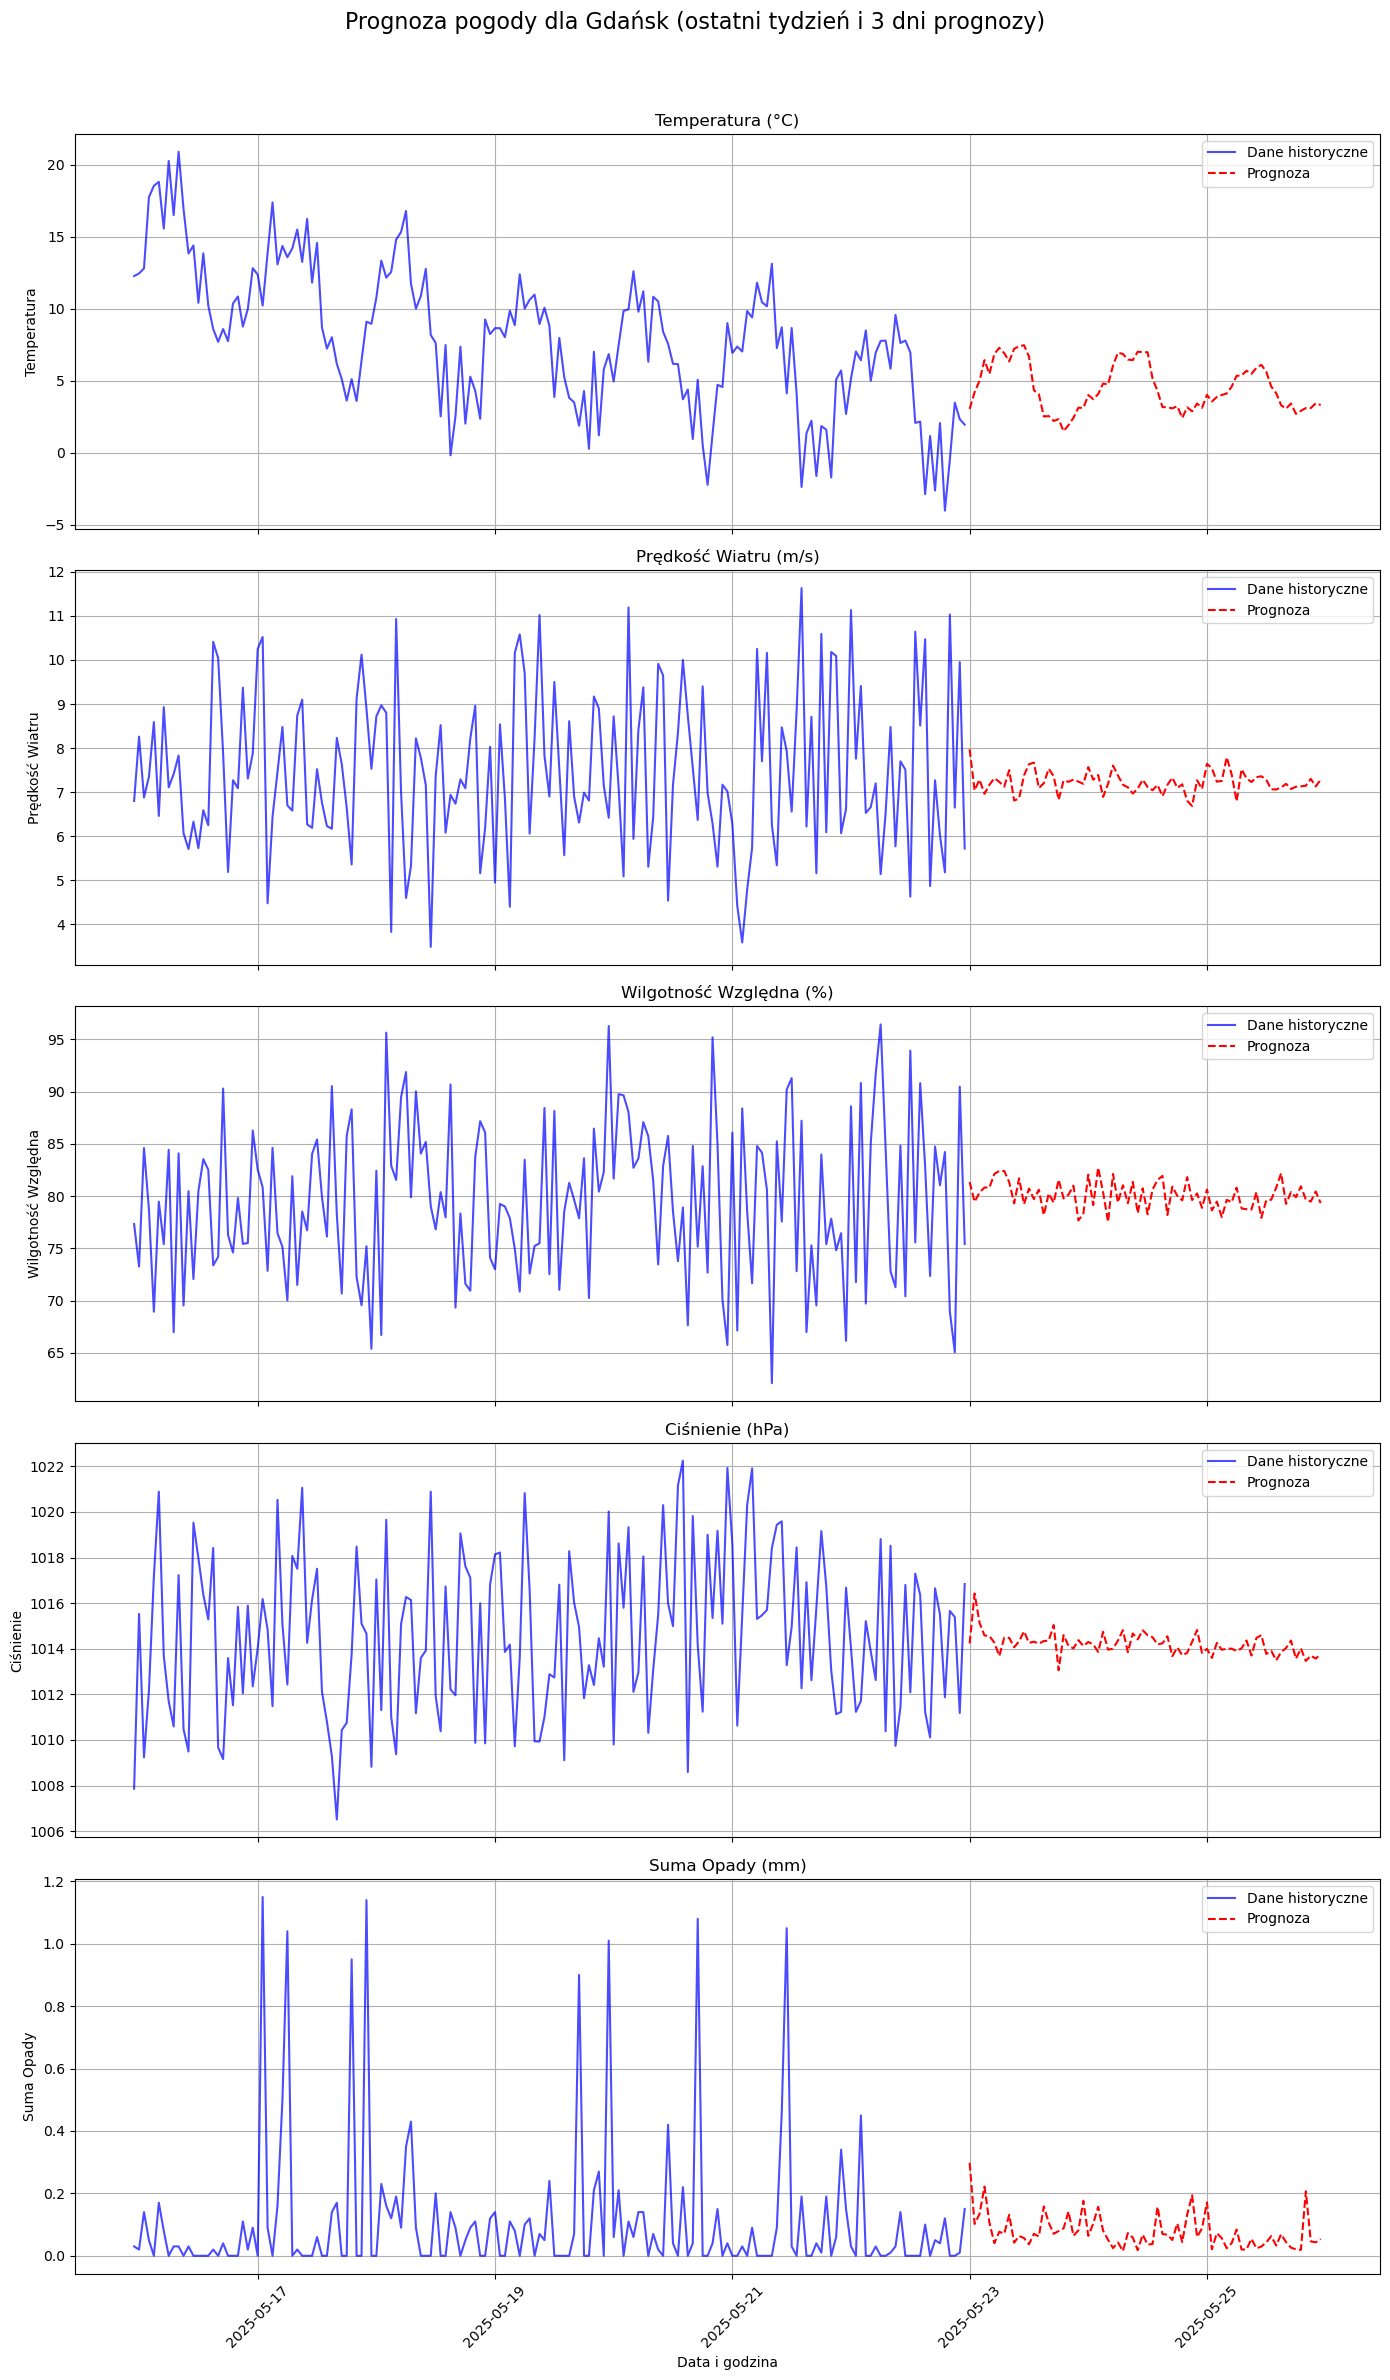


--- Prognozowanie zakończone ---


In [11]:
import requests
import pandas as pd
import time
import os
from datetime import datetime, timedelta
import sqlite3
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor 
import numpy as np
import matplotlib.pyplot as plt 

# --- Funkcje pomocnicze ---

def create_database(db_name="weather_data"):
    """
    Tworzy lub łączy się z bazą danych SQLite i zapewnia, że obie tabele (METEO, STATIONS) istnieją.
    """
    conn = sqlite3.connect(f'{db_name}.db')
    cursor = conn.cursor()

    # Tabela METEO dla danych pogodowych
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS METEO (
            Station_Id INTEGER,
            Date TEXT,
            Hour INTEGER,
            Temperature REAL,
            Wind_Speed REAL,
            Wind_Direction INTEGER,
            Relative_Humidity REAL,
            Precipitation_Total REAL,
            Pressure REAL,
            PRIMARY KEY (Station_Id, Date, Hour)
        )
    """)
    
    # Tabela STATIONS dla informacji o stacjach
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS STATIONS (
            Station_Id INTEGER PRIMARY KEY,
            Station_Name TEXT UNIQUE,
            Latitude REAL,
            Longitude REAL
        )
    """)
    conn.commit()

    # Przykładowe współrzędne dla miast (możesz dodać więcej lub pobrać z API)
    city_coordinates = {
        'Kraków': {'lat': 50.0614, 'lon': 19.9383},
        'Warszawa': {'lat': 52.2297, 'lon': 21.0122},
        'Gdańsk': {'lat': 54.3520, 'lon': 18.6464},
        'Wrocław': {'lat': 51.1079, 'lon': 17.0305},
        'Poznań': {'lat': 52.4064, 'lon': 16.9252}
    }

    for city, coords in city_coordinates.items():
        temp_id = hash(city) % 100000 
        cursor.execute("INSERT OR IGNORE INTO STATIONS (Station_Id, Station_Name) VALUES (?, ?)", 
                       (temp_id, city)) 
        cursor.execute("UPDATE STATIONS SET Latitude = ?, Longitude = ? WHERE Station_Name = ?", 
                       (coords['lat'], coords['lon'], city))
    conn.commit() 
    
    return conn, cursor


def load_data(df, table_name, conn):
    """Ładuje DataFrame do określonej tabeli w bazie danych."""
    column_mapping = {
        'id_stacji': 'Station_Id',
        'stacja': 'Station_Name', 
        'data_pomiaru': 'Date',
        'godzina_pomiaru': 'Hour',
        'temperatura': 'Temperature',
        'predkosc_wiatru': 'Wind_Speed',
        'kierunek_wiatru': 'Wind_Direction',
        'wilgotnosc_wzgledna': 'Relative_Humidity',
        'suma_opadu': 'Precipitation_Total',
        'cisnienie': 'Pressure'
    }
    
    df_renamed = df.rename(columns=column_mapping)
    df_renamed['Station_Id'] = df_renamed['Station_Id'].astype(int)

    if 'Station_Name' in df_renamed.columns:
        df_renamed = df_renamed.drop(columns=['Station_Name'])

    df_renamed.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"Dane załadowane do tabeli {table_name}.")

# --- Nowe funkcje do prognozowania ---

def simulate_historical_data(conn, cursor, cities_to_simulate, num_days=30):
    """
    Symuluje dane historyczne dla podanych miast i ładuje je do tabeli METEO.
    Generuje dane dla ostatnich 'num_days' dni, co godzinę.
    """
    print(f"Simulating historical data for {cities_to_simulate} for {num_days} days...")
    
    station_ids = {}
    for city_name in cities_to_simulate:
        cursor.execute("SELECT Station_Id FROM STATIONS WHERE station_name = ?", (city_name,))
        result = cursor.fetchone()
        if result:
            station_ids[city_name] = result[0]
        else:
            temp_id = hash(city_name) % 100000 
            cursor.execute("INSERT OR IGNORE INTO STATIONS (Station_Id, station_name) VALUES (?, ?)", (temp_id, city_name))
            conn.commit()
            station_ids[city_name] = temp_id
            print(f"Added placeholder station ID {temp_id} for {city_name} to STATIONS (during simulation).")

    today = datetime.now()
    all_simulated_data = []

    for i in range(num_days, 0, -1): 
        current_date = today - timedelta(days=i)
        for hour in range(24):
            for city_name, station_id in station_ids.items():
                temp_base = 15 + np.sin(current_date.day / 30 * 2 * np.pi) * 10 + np.sin(hour / 24 * 2 * np.pi) * 5
                wind_base = 5 + np.random.rand() * 5
                humidity_base = 70 + np.random.rand() * 20
                pressure_base = 1010 + np.random.rand() * 10
                precip_base = np.random.choice([0, 0.1, 0.5, 1], p=[0.8, 0.1, 0.05, 0.05]) 

                simulated_row = {
                    'id_stacji': station_id,
                    'stacja': city_name, 
                    'data_pomiaru': current_date.strftime('%Y-%m-%d'),
                    'godzina_pomiaru': hour,
                    'temperatura': round(temp_base + np.random.randn() * 2, 2),
                    'predkosc_wiatru': round(wind_base + np.random.randn() * 1, 2),
                    'kierunek_wiatru': np.random.randint(0, 360),
                    'wilgotnosc_wzgledna': round(humidity_base + np.random.randn() * 5, 2),
                    'suma_opadu': round(max(0, precip_base + np.random.randn() * 0.1), 2),
                    'cisnienie': round(pressure_base + np.random.randn() * 2, 2)
                }
                all_simulated_data.append(simulated_row)
    
    df_simulated = pd.DataFrame(all_simulated_data)
    load_data(df_simulated, 'METEO', conn)
    print("Historical data simulation complete.")


def fetch_city_data(conn, city_name: str):
    """Pobiera wszystkie historyczne dane dla danej stacji z bazy METEO."""
    query = """
    SELECT 
        m.Date, 
        m.Hour, 
        m.Temperature, 
        m.Wind_Speed, 
        m.Wind_Direction, 
        m.Relative_Humidity, 
        m.Precipitation_Total, 
        m.Pressure
    FROM METEO m
    JOIN STATIONS s ON m.Station_Id = s.Station_Id
    WHERE s.station_name = ?
    ORDER BY m.Date ASC, m.Hour ASC
    """
    df = pd.read_sql_query(query, conn, params=(city_name,))
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'].astype(str) + ':00:00')
    df = df.set_index('datetime').sort_index()
    return df

def prepare_forecast_data(df: pd.DataFrame, target_columns: list, lags: list):
    """
    Przygotowuje dane historyczne do prognozowania, tworząc cechy czasowe i opóźnione.
    """
    df = df[~df.index.duplicated(keep='first')]

    if not df.empty:
        full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
        df = df.reindex(full_time_range)
    else:
        print("Ostrzeżenie: Pusty DataFrame w prepare_forecast_data. Nie można utworzyć cech.")
        return pd.DataFrame()

    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month

    for col in target_columns:
        for lag in lags:
            df[f'{col}_lag_{lag}h'] = df[col].shift(lag)
    
    df_prepared = df.dropna()

    if df_prepared.empty:
        print("Ostrzeżenie: DataFrame jest pusty po usunięciu NaN. Sprawdź zakres danych historycznych i długość lagów.")
    return df_prepared

def train_and_forecast_city(df_historical: pd.DataFrame, forecast_hours: int = 72):
    """
    Trenuje model RandomForestRegressor dla każdego parametru i prognozuje na określoną liczbę godzin.
    """
    if df_historical.empty:
        print("Brak danych historycznych do prognozowania.")
        return pd.DataFrame()

    target_columns = ['Temperature', 'Wind_Speed', 'Relative_Humidity', 'Pressure', 'Precipitation_Total'] 
    feature_columns = [col for col in df_historical.columns if '_lag_' in col or col in ['hour_of_day', 'day_of_week', 'day_of_year', 'month']]
    
    if not feature_columns:
        print("Brak kolumn cech do trenowania modelu. Sprawdź funkcję prepare_forecast_data.")
        return pd.DataFrame()

    models = {}
    for target in target_columns:
        X = df_historical[feature_columns]
        y = df_historical[target]
        
        valid_indices = y.dropna().index
        X_clean = X.loc[valid_indices]
        y_clean = y.loc[valid_indices]

        if X_clean.empty:
            print(f"Brak danych do trenowania modelu dla {target}.")
            continue

        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_clean, y_clean)
        models[target] = model
    
    if not models:
        print("Nie udało się wytrenować żadnych modeli.")
        return pd.DataFrame()

    max_lag = max([1, 2, 3, 24, 48, 72]) 
    current_state_df = df_historical.iloc[-max_lag:].copy()
    
    forecast_records = []
    
    current_time = df_historical.index[-1] 

    for i in range(1, forecast_hours + 1):
        next_time = current_time + timedelta(hours=1)
        
        X_pred_dict = {}
        X_pred_dict['hour_of_day'] = next_time.hour
        X_pred_dict['day_of_week'] = next_time.dayofweek
        X_pred_dict['day_of_year'] = next_time.dayofyear
        X_pred_dict['month'] = next_time.month

        for target in target_columns: 
            for lag in [1, 2, 3, 24, 48, 72]:
                lag_col_name = f'{target}_lag_{lag}h'
                lag_time = next_time - timedelta(hours=lag)
                
                # Upewnij się, że lag_time znajduje się w indeksie current_state_df
                if lag_time in current_state_df.index:
                    X_pred_dict[lag_col_name] = current_state_df.loc[lag_time, target]
                else:
                    X_pred_dict[lag_col_name] = np.nan 

        X_pred = pd.DataFrame([X_pred_dict], columns=feature_columns)
        
        current_forecast_values = {}
        for target in target_columns:
            # Sprawdź, czy model istnieje i czy w X_pred nie ma NaN
            if target in models and not X_pred.isnull().any().any():
                predicted_value = models[target].predict(X_pred)[0]
                current_forecast_values[target] = predicted_value
            else:
                # Jeśli są NaN w cechach lub brakuje modelu, ustaw prognozę na NaN
                current_forecast_values[target] = np.nan 
        
        forecast_record = {
            'Date': next_time.strftime('%Y-%m-%d'),
            'Hour': next_time.hour,
            **current_forecast_values
        }
        forecast_records.append(forecast_record)
        
        # --- KLUCZOWA ZMIANA TUTAJ: Prawidłowe dodawanie nowego wiersza z indeksem datetime ---
        # Tworzymy DataFrame z nowym wierszem, gdzie indeks to `next_time`
        new_row_df = pd.DataFrame(current_forecast_values, index=[next_time])
        
        # Łączymy, usuwając najstarszy wiersz i dodając nowy.
        # To zapewnia, że current_state_df zawsze ma prawidłowy DatetimeIndex.
        current_state_df = pd.concat([current_state_df.iloc[1:], new_row_df])
        # --- KONIEC KLUCZOWEJ ZMIANY ---

        current_time = next_time 

    df_forecast = pd.DataFrame(forecast_records)
    return df_forecast

# --- Główny blok wykonawczy ---

if __name__ == "__main__":
    database_name = "data"
    
    if os.path.exists(f'{database_name}.db'):
        try:
            os.remove(f'{database_name}.db')
            print(f"Removed existing {database_name}.db")
        except PermissionError:
            print(f"Warning: Could not remove {database_name}.db as it's in use. Continuing with existing database.")

    # 1. Tworzenie bazy danych i zapewnienie istnienia obu tabel (METEO i STATIONS)
    conn, cursor = create_database(database_name) 
    
    # 2. Symulacja danych historycznych dla wybranych miast
    cities_to_forecast = ['Kraków', 'Warszawa', 'Gdańsk']
    simulate_historical_data(conn, cursor, cities_to_forecast, num_days=30) 

    # Po zakończeniu symulacji, zamykamy połączenie, a następnie otwieramy je ponownie,
    # aby upewnić się, że wszystkie zapisane dane są dostępne.
    conn.close() 
    conn, cursor = create_database(database_name) 

    lags_to_use = [1, 2, 3, 24, 48, 72]
    forecast_targets = ['Temperature', 'Wind_Speed', 'Relative_Humidity', 'Pressure', 'Precipitation_Total'] 

    print("\n--- Rozpoczynanie prognozowania ---")

    plot_titles = {
        'Temperature': 'Temperatura (°C)',
        'Wind_Speed': 'Prędkość Wiatru (m/s)',
        'Relative_Humidity': 'Wilgotność Względna (%)',
        'Pressure': 'Ciśnienie (hPa)',
        'Precipitation_Total': 'Suma Opady (mm)'
    }

    for city in cities_to_forecast:
        print(f"\nGenerowanie prognozy dla: {city}")
        
        # 3. Pobieranie danych historycznych dla miasta
        historical_df = fetch_city_data(conn, city)
        
        if historical_df.empty:
            print(f"Brak danych historycznych dla {city}. Pomijam prognozowanie.")
            continue

        # 4. Przygotowanie danych do prognozowania
        prepared_df = prepare_forecast_data(historical_df, forecast_targets, lags_to_use)

        if prepared_df.empty:
            print(f"Brak wystarczających danych do przygotowania cech dla {city}. Pomijam prognozowanie.")
            continue

        # 5. Trenowanie modelu i prognozowanie
        forecast_df = train_and_forecast_city(prepared_df, forecast_hours=72) 

        if not forecast_df.empty:
            print(f"\nPrognoza pogody dla {city} na najbliższe 3 dni:")
            print(forecast_df.head(5)) 
            print("...")
            print(forecast_df.tail(5)) 

            try:
                last_historical_dt = historical_df.index[-1]
                plot_start_dt = last_historical_dt - timedelta(days=7)

                historical_df_plot = historical_df[historical_df.index >= plot_start_dt]

                forecast_df_plot = forecast_df.copy()
                forecast_df_plot['datetime'] = pd.to_datetime(forecast_df_plot['Date'] + ' ' + forecast_df_plot['Hour'].astype(str) + ':00:00')
                forecast_df_plot = forecast_df_plot[forecast_df_plot['datetime'] >= plot_start_dt]

                fig, axes = plt.subplots(len(forecast_targets), 1, figsize=(14, 5 * len(forecast_targets)), sharex=True)
                fig.suptitle(f'Prognoza pogody dla {city} (ostatni tydzień i 3 dni prognozy)', fontsize=16)

                for i, target in enumerate(forecast_targets):
                    ax = axes[i]
                    ax.plot(historical_df_plot.index, historical_df_plot[target], label='Dane historyczne', alpha=0.7, color='blue')
                    ax.plot(forecast_df_plot['datetime'], forecast_df_plot[target], label='Prognoza', linestyle='--', color='red')
                    
                    ax.set_title(plot_titles.get(target, target)) 
                    ax.set_ylabel(plot_titles.get(target, target).split('(')[0].strip()) 
                    ax.legend()
                    ax.grid(True)
                
                plt.xlabel('Data i godzina')
                plt.xticks(rotation=45)
                plt.tight_layout(rect=[0, 0.03, 1, 0.96]) 
                plt.show()

            except Exception as e:
                print(f"Błąd podczas generowania wykresu dla {city}: {e}")
        else:
            print(f"Nie udało się wygenerować prognozy dla {city}.")

    conn.close()
    print("\n--- Prognozowanie zakończone ---")
